# Task:
Implement for a useful nontrivial use case of your choice the EM Algorithm
(e.g., three coins, two dice, two Gaussians, two different non-Gaussians),
surrogate data creation included. Nice documentation, commenting, presentations, take homes and animations are welcome.

## about EM Algorithm (Expectation-maximization algorithm)

The Expectation-Maximization (EM) algorithm is a method used in statistics to estimate the parameters of complex probability models. This algorithm is particularly suitable for situations where model parameters are not easily observed or calculated directly. We can think of it as a "guess-and-check" process used to progressively approximate the correct model parameters.



### Simple Explanation:

Imagine you are a detective trying to uncover the truth about an incident, but you only have incomplete clues. The EM algorithm is like initially making a preliminary guess based on the available clues (the Expectation step), then searching for more evidence to see if this guess makes sense (the Maximization step). By continuously guessing and verifying, you gradually get closer to the truth of the incident.

### Specific Steps:

1. **Expectation Step (E-step)**: Based on the current estimate of parameters, calculate or "guess" the values of hidden variables. This is like speculating possible scenarios based on the existing clues.

2. **Maximization Step (M-step)**: Update the estimation of parameters to make the model more "reasonable" for the observed data. This is similar to adjusting your clues and hypotheses based on new speculations to make the explanation of the case more reasonable.

### Example:

Imagine a classroom with two types of candies, apple-flavored and orange-flavored, stored in two different jars. We do not know how many of each flavor are in each jar, but we can randomly sample some candies from each jar to taste.

- **E-step**: Based on the current estimate (for example, initially guessing that each jar contains half apple and half orange), we try to estimate the probability of drawing each flavor from each jar.
- **M-step**: According to the data of candies tasted, adjust our estimates of the distribution of candies in the jars, for instance, finding that one jar might contain more apple-flavored candies.

By repeatedly performing these two steps, we can gradually obtain estimates of the proportion of candy flavors in each jar, even though we initially did not know the exact distribution.

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
def generate_dice_data(experiments, dice_rolls, prob_B):
    # Dice A: 正常六面骰，每面等概率
    # Dice B: 根据提供的prob_B数组决定概率分布
    results = []
    dice_types = []

    for _ in range(experiments):
        trial = []
        if random.random() < 0.5:  # 随机选择骰子A或骰子B
            dice_type = 'A'
            probabilities = [1/6] * 6  # 骰子A的概率分布
        else:
            dice_type = 'B'
            probabilities = prob_B  # 骰子B的自定义概率分布

        for _ in range(dice_rolls):
            outcome = random.choices(range(1, 7), weights=probabilities)[0]
            trial.append(outcome)
        results.append((dice_type, trial))
        dice_types.append(dice_type)
    
    return results, dice_types


In [3]:
def em_algorithm_tracking(data, max_iter=50):
    theta_A = np.random.rand(6)
    theta_B = np.random.rand(6)  # 初始化骰子B概率为0，稍后根据实际情况调整

    theta_A_history = []
    theta_B_history = []
    
    theta_A_history.append(theta_A.copy())
    theta_B_history.append(theta_B.copy())

    for _ in range(max_iter):
        counts_A = np.zeros(6)
        counts_B = np.zeros(6)

        for dice_type, trial in data:
            trial_counts_A = np.zeros(6)
            trial_counts_B = np.zeros(6)

            for outcome in trial:
                prob_A = theta_A[outcome - 1]
                prob_B = theta_B[outcome - 1]

                total_prob = prob_A + prob_B if dice_type == 'B' else prob_A
                prob_A /= total_prob
                prob_B /= total_prob

                trial_counts_A[outcome - 1] += prob_A
                if dice_type == 'B':
                    trial_counts_B[outcome - 1] += prob_B

            counts_A += trial_counts_A
            counts_B += trial_counts_B

        total_A = counts_A.sum()
        if total_A > 0:
            theta_A = counts_A / total_A

        total_B = counts_B.sum()
        if total_B > 0:
            theta_B = counts_B / total_B

        theta_A_history.append(theta_A.copy())
        theta_B_history.append(theta_B.copy())

    return theta_A, theta_B, theta_A_history, theta_B_history


[0.17996402 0.18149294 0.18043852 0.17698527 0.0987564  0.18236284] [0.45540581 0.13218003 0.13436231 0.13929788 0.         0.13875398]


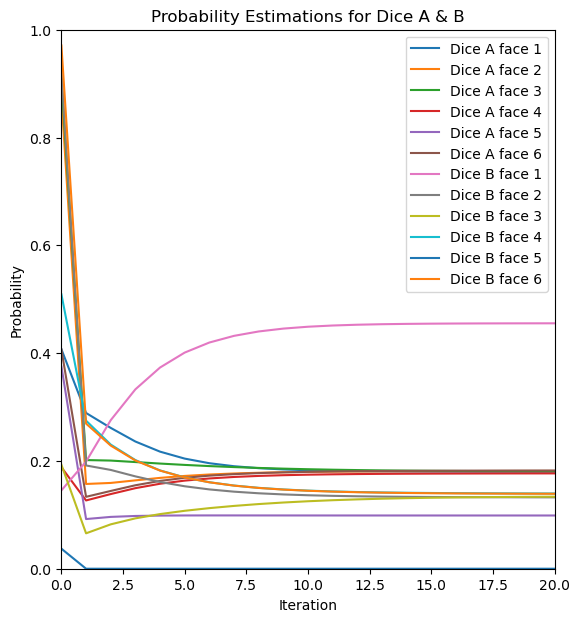

In [4]:
# 初始化数据
data, dice_types = generate_dice_data(100, 1000,[2/6,1/6,1/6,1/6,0,1/6])  # 生成较多的数据以提高估计的准确性
final_theta_A, final_theta_B, theta_A_history, theta_B_history = em_algorithm_tracking(data, 100)

print(final_theta_A, final_theta_B)

# 可视化迭代过程
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
for i in range(6):
    plt.plot([theta[i] for theta in theta_A_history], label=f'Dice A face {i+1}')
for i in range(6):
    plt.plot([theta[i] for theta in theta_B_history], label=f'Dice B face {i+1}')

plt.ylim(0,1)
plt.xlim(0,20)
plt.title('Probability Estimations for Dice A & B')
plt.xlabel('Iteration')
plt.ylabel('Probability')
plt.legend()

plt.show()


In [5]:
import matplotlib.pyplot as plt

def plot_dice_likelihood(rolls, theta_A_history, theta_B_history):
    # 设置图表大小
    plt.figure(figsize=(12, 6))

    # 绘制骰子A的概率变化
    plt.subplot(1, 2, 1)
    for i in range(6):
        plt.plot([theta[i] for theta in theta_A_history], label=f'Face {i+1}')
    plt.ylim(0,1)
    plt.title('Probability Estimations for Dice A Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Probability')
    plt.legend()

    # 绘制骰子B的概率变化
    plt.subplot(1, 2, 2)
    for i in range(6):
        plt.plot([theta[i] for theta in theta_B_history], label=f'Face {i+1}')
    plt.ylim(0,1)
    plt.title('Probability Estimations for Dice B Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Probability')
    plt.legend()

    plt.tight_layout()
    plt.show()


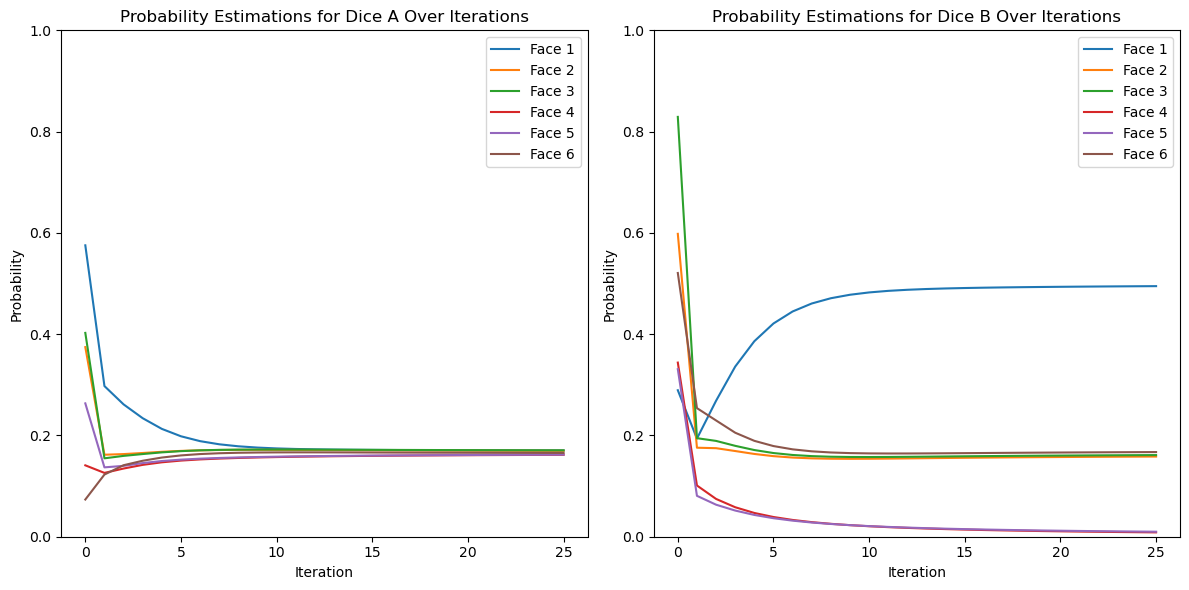

[0.17036393 0.16972863 0.1706168  0.16172898 0.16208933 0.16547233] [0.49483164 0.15832301 0.16120652 0.00858177 0.00988305 0.16717401]


In [6]:
data, dice_types = generate_dice_data(100, 1000,[2/6,1/6,1/6,1/12,1/12,1/6])
final_theta_A, final_theta_B, theta_A_history, theta_B_history = em_algorithm_tracking(data, 25)
plot_dice_likelihood(data, theta_A_history, theta_B_history)
print(final_theta_A, final_theta_B)

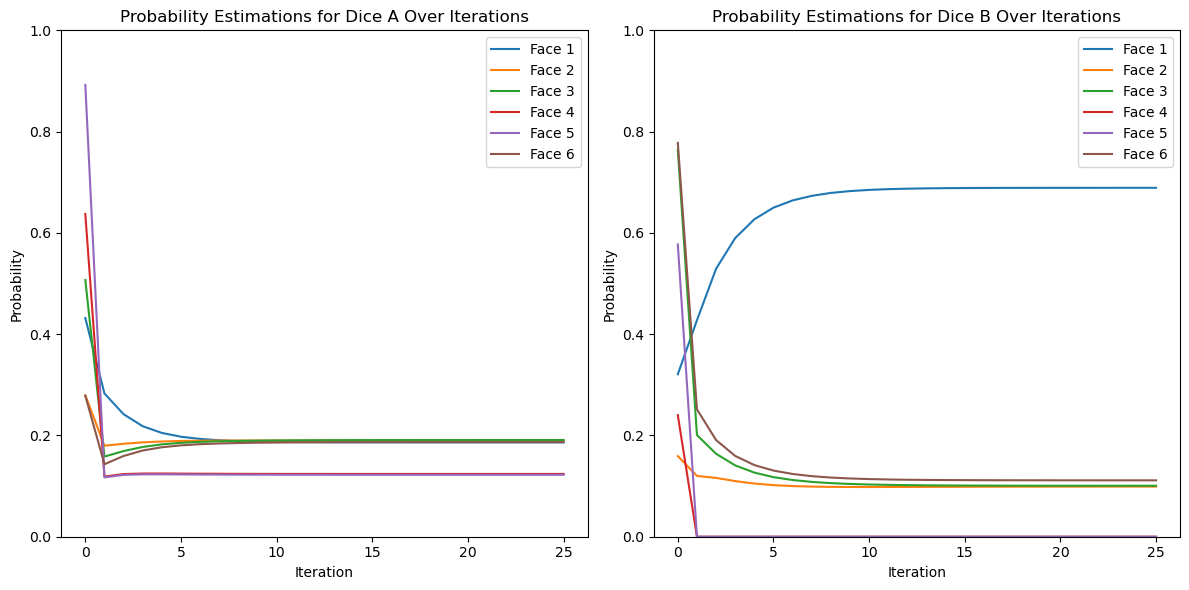


[0.18630131 0.18958166 0.19097333 0.12397144 0.12234378 0.18682847] [0.68901831 0.09904623 0.10058728 0.         0.         0.11134817]


In [7]:
data, dice_types = generate_dice_data(100, 1000,[3/6, 1/6, 1/6 ,0, 0, 1/6])
final_theta_A, final_theta_B, theta_A_history, theta_B_history = em_algorithm_tracking(data, 25)
plot_dice_likelihood(data, theta_A_history, theta_B_history)
print()
print(final_theta_A, final_theta_B)

In [8]:
 np.random.rand(6)

array([0.13538774, 0.30658544, 0.92915757, 0.77568658, 0.01127455,
       0.88035191])